步骤 1：数据读取
读取附件1中的负荷数据和附件2中的风光发电数据。

In [170]:
import pandas as pd

# 读取负荷数据
load_data = pd.read_excel('附件1：各园区典型日负荷数据.xlsx', sheet_name='Sheet1')

# 读取风光发电数据
generation_data = pd.read_excel('附件2：各园区典型日风光发电数据.xlsx', sheet_name='Sheet1')

# 检查数据
print(load_data.head())
print(generation_data.head())


      时间（h）  Load_A  Purchase_A  Different_A  Load_B  Purchase_B  Different_B  \
0  00:00:00     275       275.0          0.0     241        10.9        230.1   
1  01:00:00     275       275.0          0.0     253         0.0        253.0   
2  02:00:00     277       277.0          0.0     329        32.2        296.8   
3  03:00:00     310       310.0          0.0     315         0.0        315.0   
4  04:00:00     310       310.0          0.0     290         0.0        290.0   

   Load_C  Purchase_C  
0     302      228.80  
1     292      183.25  
2     307      109.05  
3     293      201.45  
4     271       35.20  
      时间（h）  Solar_A  Wind_A  Wind_B  Solar_C  Wind_C  So_A  W_A     W_B  \
0  00:00:00      0.0       0   230.1      0.0   73.20   0.0    0  0.2301   
1  01:00:00      0.0       0   382.8      0.0  108.75   0.0    0  0.3828   
2  02:00:00      0.0       0   296.8      0.0  197.95   0.0    0  0.2968   
3  03:00:00      0.0       0   444.4      0.0   91.55   0.0    0 

步骤 2：储能系统的参数设置
设置储能系统的参数，包括功率、能量容量、充放电效率和SOC范围。

In [171]:
# 储能系统参数
storage_power = 50  # kW
storage_capacity = 100  # kWh
charge_discharge_efficiency = 0.95
soc_min = 0.1
soc_max = 0.9


步骤 3：储能最优运行策略
定义储能系统的最优运行策略，以尽量减少购电量和弃电量。

In [172]:
# 读取Excel文件并打印列名
load_data = pd.read_excel('附件1：各园区典型日负荷数据.xlsx', sheet_name='Sheet1')
print("Load Data Columns:", load_data.columns)

purchase_data = pd.read_excel('附件1：各园区典型日负荷数据.xlsx', sheet_name='Sheet1')
different_data = pd.read_excel('附件1：各园区典型日负荷数据.xlsx', sheet_name='Sheet1')
print("Purchase Data Columns:", purchase_data.columns)
print("Different Data Columns:", different_data.columns)

generation_data = pd.read_excel('附件2：各园区典型日风光发电数据.xlsx', sheet_name='Sheet1')
print("Generation Data Columns:", generation_data.columns)


Load Data Columns: Index(['时间（h）', 'Load_A', 'Purchase_A', 'Different_A', 'Load_B', 'Purchase_B',
       'Different_B', 'Load_C', 'Purchase_C'],
      dtype='object')
Purchase Data Columns: Index(['时间（h）', 'Load_A', 'Purchase_A', 'Different_A', 'Load_B', 'Purchase_B',
       'Different_B', 'Load_C', 'Purchase_C'],
      dtype='object')
Different Data Columns: Index(['时间（h）', 'Load_A', 'Purchase_A', 'Different_A', 'Load_B', 'Purchase_B',
       'Different_B', 'Load_C', 'Purchase_C'],
      dtype='object')
Generation Data Columns: Index(['时间（h）', 'Solar_A', 'Wind_A', 'Wind_B', 'Solar_C', 'Wind_C', 'So_A',
       'W_A', 'W_B', 'So_C', 'W_C'],
      dtype='object')


In [173]:
import numpy as np

# 初始化SOC
soc = 0.5 * storage_capacity  # 初始SOC设为50%容量

# 储能运行策略函数
def storage_operation(load, solar, wind, soc, storage_capacity, storage_power, charge_discharge_efficiency, soc_min, soc_max):
    net_load = load - solar - wind
    if net_load > 0:
        # 负荷大于发电量，需要放电
        discharge = min(net_load, storage_power, (soc - soc_min * storage_capacity) / charge_discharge_efficiency)
        soc -= discharge * charge_discharge_efficiency
        net_load -= discharge
    else:
        # 发电量大于负荷，需要充电
        charge = min(-net_load, storage_power, (soc_max * storage_capacity - soc) * charge_discharge_efficiency)
        soc += charge / charge_discharge_efficiency
        net_load += charge
    
    return net_load, soc


In [174]:

# 模拟一天的运行
load_a = load_data['Load_A'].values
purchase_a = purchase_data['Purchase_A'].values
different_data = load_data['Different_A'].values
load_b = load_data['Load_B'].values
print(load_a)
print(purchase_a)
print(different_data)
print(load_b)

[275 275 277 310 310 293 293 380 375 281 447 447 447 405 404 403 268 313
 287 288 284 287 277 275]
[275.    275.    277.    310.    310.    293.    293.    375.65  148.05
   0.      0.      0.      0.      0.      0.     84.85  221.575 313.
 287.    288.    284.    287.    277.    275.   ]
[  0.      0.      0.      0.      0.      0.      0.      4.35  226.95
 281.    447.    447.    447.    405.    404.    318.15   46.425   0.
   0.      0.      0.      0.      0.      0.   ]
[241 253 329 315 290 270 307 354 264 315 313 291 360 369 389 419 412 291
 379 303 331 306 285 324]


In [175]:

print(generation_data.columns)
solar_a = generation_data['Solar_A'].values


Index(['时间（h）', 'Solar_A', 'Wind_A', 'Wind_B', 'Solar_C', 'Wind_C', 'So_A',
       'W_A', 'W_B', 'So_C', 'W_C'],
      dtype='object')


In [176]:

wind_a = generation_data['Wind_A'].values


In [183]:

net_load_a = []
net_purchase_a = []
net_different_a = []
soc_values_a = []


[]
[]
[]


In [190]:
for i in range(len(load_a)):
    net_load, soc = storage_operation(load_a[i], solar_a[i], wind_a[i], soc, storage_capacity, storage_power, charge_discharge_efficiency, soc_min, soc_max)
    net_load_a.append(net_load)
    soc_values_a.append(soc)

AttributeError: 'numpy.float64' object has no attribute 'append'

In [182]:
# 转为numpy数组
net_load_a = np.array(net_load_a)
net_purchase_a = np.array(net_purchase_a)
net_different_a = np.array(net_different_a)
print(net_load_a)
print(net_purchase_a)
print(net_different_a)

[ 232.89473684  275.          277.          310.          310.
  293.          293.          375.65        148.05       -120.5
 -105.325      -194.625      -192.825      -183.15        -78.775
   34.85        187.36447368  313.          287.          288.
  284.          287.          277.          275.        ]
[]
[]


In [180]:

soc_values_a = np.array(soc_values_a)
print(net_load_a)
print(soc_values_a)

[ 232.89473684  275.          277.          310.          310.
  293.          293.          375.65        148.05       -120.5
 -105.325      -194.625      -192.825      -183.15        -78.775
   34.85        187.36447368  313.          287.          288.
  284.          287.          277.          275.        ]
[10.         10.         10.         10.         10.         10.
 10.         10.         10.         62.63157895 90.         90.
 90.         90.         90.         42.5        10.         10.
 10.         10.         10.         10.         10.         10.        ]


步骤 4：购电计划和经济性分析
根据储能策略计算购电量、弃电量和总供电成本，并比较配置储能前后的经济性。

In [181]:
# 购电价格
grid_price = 0.4  # 元/kWh

# 计算购电量和弃电量
grid_purchase_a = np.maximum(net_different_a, 0)
abandoned_solar_a = np.maximum(-net_different_a, 0) * (generation_data['Solar_A'].values > 0)
abandoned_wind_a = np.maximum(-net_different_a, 0) * (generation_data['Wind_A'].values > 0)

# 计算总供电成本
total_cost_a = np.sum(grid_purchase_a * grid_price)

# 未配置储能时的购电量和总供电成本
grid_purchase_no_storage_a = np.maximum(load_a - solar_a - wind_a, 0)
total_cost_no_storage_a = np.sum(grid_purchase_no_storage_a * grid_price)

# 打印结果
print(f"配置储能后的总供电成本: {total_cost_a} 元")
print(f"未配置储能时的总供电成本: {total_cost_no_storage_a} 元")


ValueError: operands could not be broadcast together with shapes (0,) (24,) 

步骤 5：分析结果
对比配置储能前后的经济性结果，分析储能系统对各园区运行经济性的改善情况。

配置储能后的总供电成本是否降低。
弃风弃光电量是否减少。
购电量是否减少。

      时间（h）  Load_A  Purchase_A  Different_A  Load_B  Purchase_B  Different_B  \
0  00:00:00     275       275.0          0.0     241        10.9        230.1   
1  01:00:00     275       275.0          0.0     253         0.0        253.0   
2  02:00:00     277       277.0          0.0     329        32.2        296.8   
3  03:00:00     310       310.0          0.0     315         0.0        315.0   
4  04:00:00     310       310.0          0.0     290         0.0        290.0   

   Load_C  Purchase_C  
0     302      228.80  
1     292      183.25  
2     307      109.05  
3     293      201.45  
4     271       35.20  
      时间（h）  Solar_A  Wind_A  Wind_B  Solar_C  Wind_C  So_A  W_A     W_B  \
0  00:00:00      0.0       0   230.1      0.0   73.20   0.0    0  0.2301   
1  01:00:00      0.0       0   382.8      0.0  108.75   0.0    0  0.3828   
2  02:00:00      0.0       0   296.8      0.0  197.95   0.0    0  0.2968   
3  03:00:00      0.0       0   444.4      0.0   91.55   0.0    0 

TypeError: can only concatenate tuple (not "float") to tuple

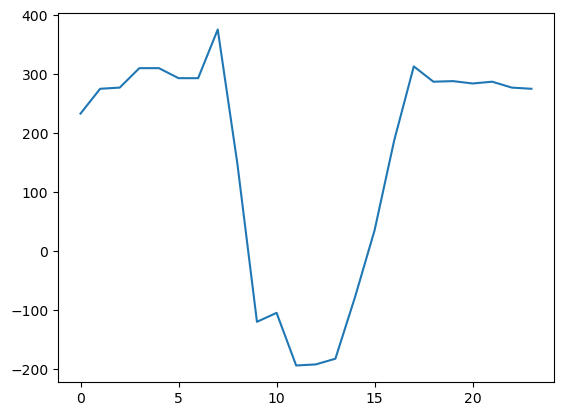

In [191]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取负荷数据
load_data = pd.read_excel('附件1：各园区典型日负荷数据.xlsx', sheet_name='Sheet1')

# 读取风光发电数据
generation_data = pd.read_excel('附件2：各园区典型日风光发电数据.xlsx', sheet_name='Sheet1')

# 检查数据
print(load_data.head())
print(generation_data.head())

# 储能系统参数
storage_power = 50  # kW
storage_capacity = 100  # kWh
charge_discharge_efficiency = 0.95
soc_min = 0.1
soc_max = 0.9

# 读取Excel文件并打印列名
load_data = pd.read_excel('附件1：各园区典型日负荷数据.xlsx', sheet_name='Sheet1')
print("Load Data Columns:", load_data.columns)

generation_data = pd.read_excel('附件2：各园区典型日风光发电数据.xlsx', sheet_name='Sheet1')
print("Generation Data Columns:", generation_data.columns)


import numpy as np

# 初始化SOC
soc = 0.5 * storage_capacity  # 初始SOC设为50%容量

# 储能运行策略函数
def storage_operation(load, solar, wind, soc, storage_capacity, storage_power, charge_discharge_efficiency, soc_min, soc_max):
    net_load = load - solar - wind
    if net_load > 0:
        # 负荷大于发电量，需要放电
        discharge = min(net_load, storage_power, (soc - soc_min * storage_capacity) / charge_discharge_efficiency)
        soc -= discharge * charge_discharge_efficiency
        net_load -= discharge
    else:
        # 发电量大于负荷，需要充电
        charge = min(-net_load, storage_power, (soc_max * storage_capacity - soc) * charge_discharge_efficiency)
        soc += charge / charge_discharge_efficiency
        net_load += charge
    
    return net_load, soc


# 模拟一天的运行
load_a = load_data['Load_A'].values
solar_a = generation_data['Solar_A'].values
wind_a = generation_data['Wind_A'].values

net_load_a = []
soc_values_a = []

for i in range(len(load_a)):
    net_load, soc = storage_operation(load_a[i], solar_a[i], wind_a[i], soc, storage_capacity, storage_power, charge_discharge_efficiency, soc_min, soc_max)
    net_load_a.append(net_load)
    soc_values_a.append(soc)

# 转为numpy数组
net_load_a = np.array(net_load_a)
soc_values_a = np.array(soc_values_a)
# 绘制折线图
plt.plot(net_load_a, label='Net Load')

# 购电价格
grid_price = 1  # 元/kWh

# 园区价格
park_price = 0.4  # 元/kWh

# 综合价格
composite_price = grid_price*() + park_price

# 计算购电量和弃电量
grid_purchase_a = np.maximum(net_load_a, 0)
abandoned_solar_a = np.maximum(-net_load_a, 0) * (generation_data['Solar_A'].values > 0)
abandoned_wind_a = np.maximum(-net_load_a, 0) * (generation_data['Wind_A'].values > 0)

# 计算总供电成本
total_cost_a = np.sum(grid_purchase_a * grid_price)

# 未配置储能时的购电量和总供电成本
grid_purchase_no_storage_a = np.maximum(load_a - solar_a - wind_a, 0)
total_cost_no_storage_a = np.sum(grid_purchase_no_storage_a * grid_price)

# 打印结果
print(f"配置储能后的总供电成本: {total_cost_a} 元")
print(f"未配置储能时的总供电成本: {total_cost_no_storage_a} 元")


In [193]:
import pandas as pd

# 读取Excel文件
load_data = pd.read_excel('附件1：各园区典型日负荷数据.xlsx', sheet_name='Sheet1')
generation_data = pd.read_excel('附件2：各园区典型日风光发电数据.xlsx', sheet_name='Sheet1')

# 打印列名
print("Load Data Columns:", load_data.columns)
print("Generation Data Columns:", generation_data.columns)

# 如果需要，重命名列
load_data = load_data.rename(columns={'实际的列名': 'Load_A', '...': '...'})
generation_data = generation_data.rename(columns={'实际的列名': 'Solar_A', '...': '...'})

# 储能系统参数
storage_power = 50  # kW
storage_capacity = 100  # kWh
charge_discharge_efficiency = 0.95
soc_min = 0.1
soc_max = 0.9

# 初始化SOC
soc = 0.5 * storage_capacity  # 初始SOC设为50%容量

# 储能运行策略函数
def storage_operation(load, solar, wind, soc, storage_capacity, storage_power, charge_discharge_efficiency, soc_min, soc_max):
    net_load = load - solar - wind
    if net_load > 0:
        # 负荷大于发电量，需要放电
        discharge = min(net_load, storage_power, (soc - soc_min * storage_capacity) / charge_discharge_efficiency)
        soc -= discharge * charge_discharge_efficiency
        net_load -= discharge
    else:
        # 发电量大于负荷，需要充电
        charge = min(-net_load, storage_power, (soc_max * storage_capacity - soc) * charge_discharge_efficiency)
        soc += charge / charge_discharge_efficiency
        net_load += charge
    
    return net_load, soc

# 模拟一天的运行
load_a = load_data['Load_A'].values
solar_a = generation_data['Solar_A'].values
wind_a = generation_data['Wind_A'].values
net_load_a = []
soc_values_a = []

for i in range(len(load_a)):
    net_load, soc = storage_operation(load_a[i], solar_a[i], wind_a[i], soc, storage_capacity, storage_power, charge_discharge_efficiency, soc_min, soc_max)
    net_load_a.append(net_load)
    soc_values_a.append(soc)
    
# 转为numpy数组
net_load_a = np.array(net_load_a)
soc_values_a = np.array(soc_values_a)

# 购电价格
grid_price = 0.4 # 元/kWh

# 计算购电量和弃电量
grid_purchase_a = np.maximum(net_load_a, 0)
abandoned_solar_a = np.maximum(-net_load_a, 0) * (generation_data['Solar_A'].values > 0)
abandoned_wind_a = np.maximum(-net_load_a, 0) * (generation_data['Wind_A'].values > 0)

# 计算总供电成本
total_cost_a = np.sum(grid_purchase_a * grid_price)

# 未配置储能时的购电量和总供电成本
grid_purchase_no_storage_a = np.maximum(load_a - solar_a - wind_a, 0)
total_cost_no_storage_a = np.sum(grid_purchase_no_storage_a * grid_price)

# 打印结果
print(f"配置储能后的总供电成本: {total_cost_a} 元")
print(f"未配置储能时的总供电成本: {total_cost_no_storage_a} 元")


Load Data Columns: Index(['时间（h）', 'Load_A', 'Purchase_A', 'Different_A', 'Load_B', 'Purchase_B',
       'Different_B', 'Load_C', 'Purchase_C'],
      dtype='object')
Generation Data Columns: Index(['时间（h）', 'Solar_A', 'Wind_A', 'Wind_B', 'Solar_C', 'Wind_C', 'So_A',
       'W_A', 'W_B', 'So_C', 'W_C'],
      dtype='object')
配置储能后的总供电成本: 1899.1236842105263 元
未配置储能时的总供电成本: 1949.65 元


Load Data Columns: Index(['时间（h）', 'Load_A', 'Purchase_A', 'Different_A', 'Load_B', 'Purchase_B',
       'Different_B', 'Load_C', 'Purchase_C'],
      dtype='object')
Generation Data Columns: Index(['时间（h）', 'Solar_A', 'Wind_A', 'Wind_B', 'Solar_C', 'Wind_C', 'So_A',
       'W_A', 'W_B', 'Solar_C.1', 'W_C'],
      dtype='object')
配置储能后的总供电成本: 4747.809210526316 元
未配置储能时的总供电成本: 4874.125 元


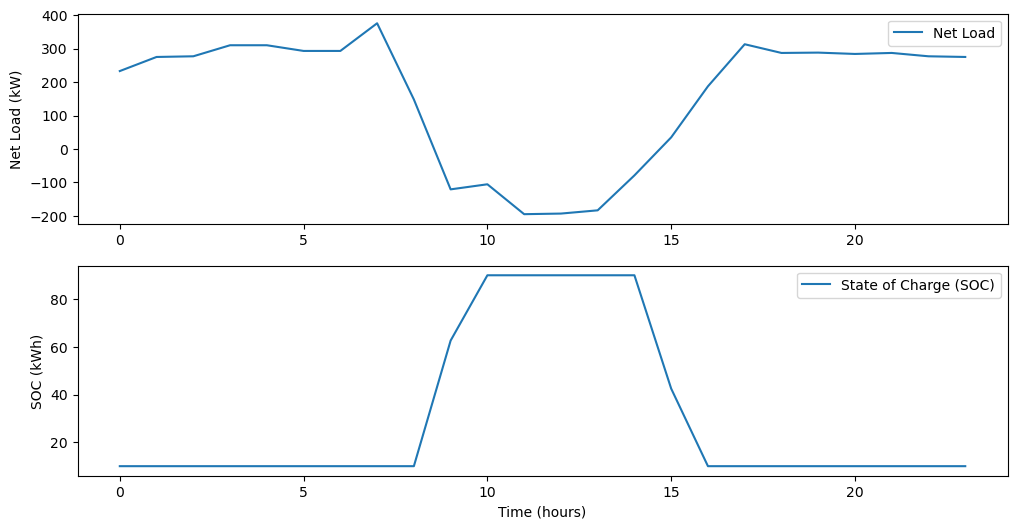

In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取Excel文件
load_data = pd.read_excel('附件1：各园区典型日负荷数据.xlsx', sheet_name='Sheet1')
generation_data = pd.read_excel('附件2：各园区典型日风光发电数据.xlsx', sheet_name='Sheet1')

# 打印列名
print("Load Data Columns:", load_data.columns)
print("Generation Data Columns:", generation_data.columns)

# 如果需要，重命名列
#load_data = load_data.rename(columns={'原来的列名1': 'Load_A', '原来的列名2': '其他列'})
#generation_data = generation_data.rename(columns={'原来的列名3': 'Solar_A', '原来的列名4': 'Wind_A'})

# 储能系统参数
storage_power = 50  # kW
storage_capacity = 100  # kWh
charge_discharge_efficiency = 0.95
soc_min = 0.1
soc_max = 0.9

# 初始化SOC
soc = 0.5 * storage_capacity  # 初始SOC设为50%容量

# 储能运行策略函数
def storage_operation(load, solar, wind, soc, storage_capacity, storage_power, charge_discharge_efficiency, soc_min, soc_max):
    net_load = load - solar - wind
    if net_load > 0:
        # 负荷大于发电量，需要放电
        discharge = min(net_load, storage_power, (soc - soc_min * storage_capacity) / charge_discharge_efficiency)
        soc -= discharge * charge_discharge_efficiency
        net_load -= discharge
    else:
        # 发电量大于负荷，需要充电
        charge = min(-net_load, storage_power, (soc_max * storage_capacity - soc) * charge_discharge_efficiency)
        soc += charge / charge_discharge_efficiency
        net_load += charge
    
    # 确保SOC在范围内
    soc = max(soc_min * storage_capacity, min(soc, soc_max * storage_capacity))
    
    return net_load, soc

# 模拟一天的运行
load_a = load_data['Load_A'].values
solar_a = generation_data['Solar_A'].values
wind_a = generation_data['Wind_A'].values
net_load_a = []
soc_values_a = []

for i in range(len(load_a)):
    net_load, soc = storage_operation(load_a[i], solar_a[i], wind_a[i], soc, storage_capacity, storage_power, charge_discharge_efficiency, soc_min, soc_max)
    net_load_a.append(net_load)
    soc_values_a.append(soc)

# 转为numpy数组
net_load_a = np.array(net_load_a)
soc_values_a = np.array(soc_values_a)

# 购电价格
grid_price = 1 # 元/kWh

# 计算购电量和弃电量
grid_purchase_a = np.maximum(net_load_a, 0)
abandoned_solar_a = np.maximum(-net_load_a, 0) * (generation_data['Solar_A'].values > 0)
abandoned_wind_a = np.maximum(-net_load_a, 0) * (generation_data['Wind_A'].values > 0)

# 计算总供电成本
total_cost_a = np.sum(grid_purchase_a * grid_price)

# 未配置储能时的购电量和总供电成本
grid_purchase_no_storage_a = np.maximum(load_a - solar_a - wind_a, 0)
total_cost_no_storage_a = np.sum(grid_purchase_no_storage_a * grid_price)

# 打印结果
print(f"配置储能后的总供电成本: {total_cost_a} 元")
print(f"未配置储能时的总供电成本: {total_cost_no_storage_a} 元")

# 绘制SOC和净负荷变化图
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(net_load_a, label='Net Load')
plt.ylabel('Net Load (kW)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(soc_values_a, label='State of Charge (SOC)')
plt.ylabel('SOC (kWh)')
plt.legend()

plt.xlabel('Time (hours)')
plt.show()


购电成本的计算：

从主电网购电成本：total_grid_cost_a = np.sum(grid_purchase_a * grid_price)
从风电购电成本：total_wind_cost_a = np.sum(np.minimum(wind_a, load_a - solar_a) * wind_price)
从光伏购电成本：total_solar_cost_a = np.sum(np.minimum(solar_a, load_a - wind_a) * solar_price)
储能系统成本：

功率单价和能量单价根据10年寿命均摊计算到每小时的成本。
total_storage_cost = (storage_cost_power + storage_cost_energy) / (lifetime * 365 * 24)
总供电成本：

配置储能后的总供电成本为购电成本加上储能系统的均摊成本。
total_cost_a = total_grid_cost_a + total_wind_cost_a + total_solar_cost_a + total_storage_cost * len(load_a)
绘图：

绘制了SOC（充放电状态）和净负荷变化图。
新增了供电量的柱状图，包括主电网购电量和弃电量。

对园区A进行测试

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取Excel文件
load_data = pd.read_excel('附件1：各园区典型日负荷数据.xlsx', sheet_name='Sheet1')
generation_data = pd.read_excel('附件2：各园区典型日风光发电数据.xlsx', sheet_name='Sheet1')


Load Data Columns: Index(['时间（h）', 'Load_A', 'Purchase_A', 'Different_A', 'Load_B', 'Purchase_B',
       'Different_B', 'Load_C', 'Purchase_C'],
      dtype='object')
Generation Data Columns: Index(['时间（h）', 'Solar_A', 'Wind_A', 'Wind_B', 'Solar_C', 'Wind_C', 'So_A',
       'W_A', 'W_B', 'Solar_C.1', 'W_C'],
      dtype='object')
配置储能后的总供电成本: 4755.46101297765 元
未配置储能时的总供电成本: 5609.275 元


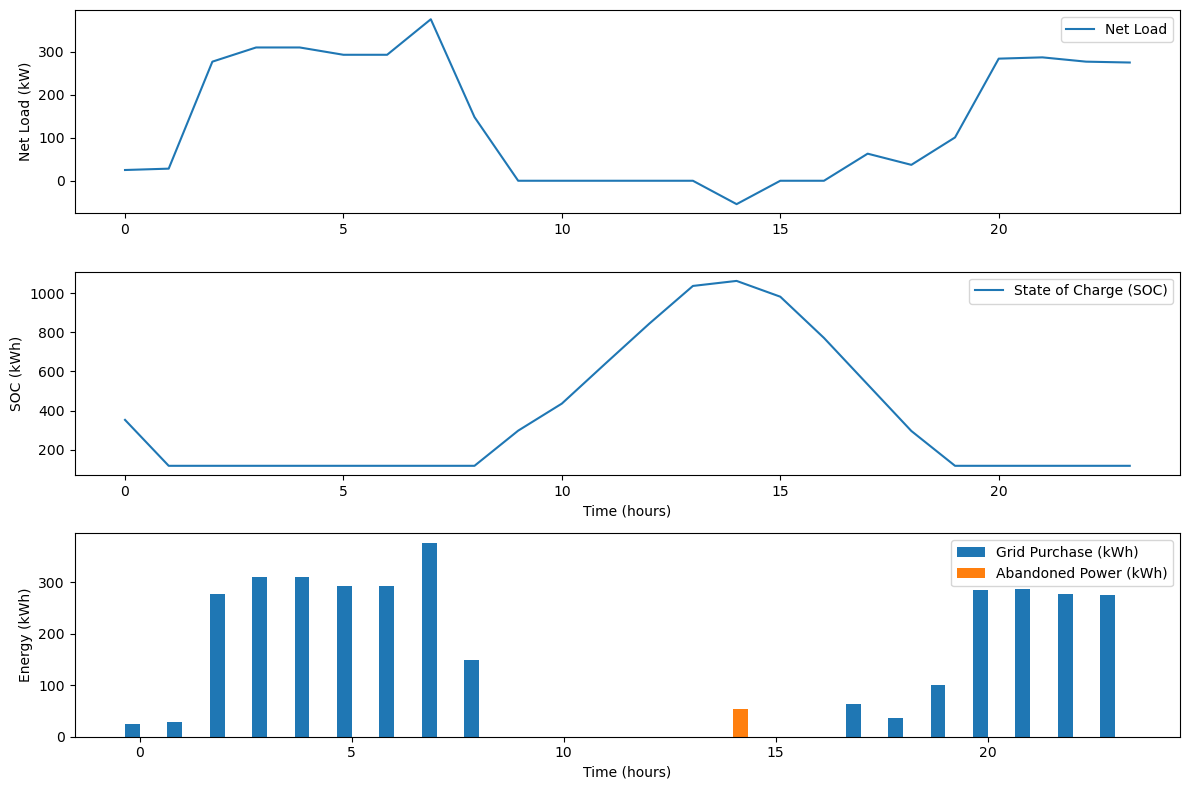

In [3]:

# 打印列名
print("Load Data Columns:", load_data.columns)
print("Generation Data Columns:", generation_data.columns)

# 如果需要，重命名列
load_data = load_data.rename(columns={'原来的列名1': 'Load_A', '原来的列名2': '其他列'})
generation_data = generation_data.rename(columns={'原来的列名3': 'Solar_A', '原来的列名4': 'Wind_A'})

# 储能系统参数
storage_power = 250  # kW
storage_capacity = 1180  # kWh
charge_discharge_efficiency = 0.95
soc_min = 0.1
soc_max = 0.9
lifetime = 10  # years

# 初始化SOC
soc = 0.5 * storage_capacity  # 初始SOC设为50%容量

# 购电价格
grid_price = 1  # 元/kWh
wind_price = 0.5  # 元/kWh
solar_price = 0.4  # 元/kWh

# 储能系统成本计算
storage_cost_power = storage_power * 800  # 元
storage_cost_energy = storage_capacity * 1800  # 元
total_storage_cost = (storage_cost_power + storage_cost_energy) / (lifetime * 365 * 24)  # 元/h

# 储能运行策略函数
def storage_operation(load, solar, wind, soc, storage_capacity, storage_power, charge_discharge_efficiency, soc_min, soc_max):
    net_load = load - solar - wind
    if net_load > 0:
        # 负荷大于发电量，需要放电
        discharge = min(net_load, storage_power, (soc - soc_min * storage_capacity) / charge_discharge_efficiency)
        soc -= discharge * charge_discharge_efficiency
        net_load -= discharge
    else:
        # 发电量大于负荷，需要充电
        charge = min(-net_load, storage_power, (soc_max * storage_capacity - soc) * charge_discharge_efficiency)
        soc += charge / charge_discharge_efficiency
        net_load += charge
    
    # 确保SOC在范围内
    soc = max(soc_min * storage_capacity, min(soc, soc_max * storage_capacity))
    
    return net_load, soc

# 模拟一天的运行
load_a = load_data['Load_A'].values
solar_a = generation_data['Solar_A'].values
wind_a = generation_data['Wind_A'].values
net_load_a = []
soc_values_a = []

for i in range(len(load_a)):
    net_load, soc = storage_operation(load_a[i], solar_a[i], wind_a[i], soc, storage_capacity, storage_power, charge_discharge_efficiency, soc_min, soc_max)
    net_load_a.append(net_load)
    soc_values_a.append(soc)

# 转为numpy数组
net_load_a = np.array(net_load_a)
soc_values_a = np.array(soc_values_a)

# 计算购电量和弃电量
grid_purchase_a = np.maximum(net_load_a, 0)
abandoned_solar_a = np.maximum(-net_load_a, 0) * (generation_data['Solar_A'].values > 0)
abandoned_wind_a = np.maximum(-net_load_a, 0) * (generation_data['Wind_A'].values > 0)

# 计算总供电成本
total_grid_cost_a = np.sum(grid_purchase_a * grid_price)
total_wind_cost_a = np.sum(np.minimum(wind_a, load_a - solar_a) * wind_price)
total_solar_cost_a = np.sum(np.minimum(solar_a, load_a - wind_a) * solar_price)

total_cost_a = total_grid_cost_a + total_wind_cost_a + total_solar_cost_a + total_storage_cost * len(load_a)

# 未配置储能时的购电量和总供电成本
grid_purchase_no_storage_a = np.maximum(load_a - solar_a - wind_a, 0)
total_grid_cost_no_storage_a = np.sum(grid_purchase_no_storage_a * grid_price)
total_wind_cost_no_storage_a = np.sum(np.minimum(wind_a, load_a - solar_a) * wind_price)
total_solar_cost_no_storage_a = np.sum(np.minimum(solar_a, load_a - wind_a) * solar_price)

total_cost_no_storage_a = total_grid_cost_no_storage_a + total_wind_cost_no_storage_a + total_solar_cost_no_storage_a

# 打印结果
print(f"配置储能后的总供电成本: {total_cost_a} 元")
print(f"未配置储能时的总供电成本: {total_cost_no_storage_a} 元")

# 绘制SOC和净负荷变化图
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(net_load_a, label='Net Load')
plt.ylabel('Net Load (kW)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(soc_values_a, label='State of Charge (SOC)')
plt.ylabel('SOC (kWh)')
plt.legend()

plt.xlabel('Time (hours)')

# 绘制供电量柱状图
time = np.arange(len(load_a))
width = 0.35

plt.subplot(3, 1, 3)
plt.bar(time - width/2, grid_purchase_a, width, label='Grid Purchase (kWh)')
plt.bar(time + width/2, abandoned_solar_a + abandoned_wind_a, width, label='Abandoned Power (kWh)')
plt.ylabel('Energy (kWh)')
plt.xlabel('Time (hours)')
plt.legend()

plt.tight_layout()
plt.show()

对园区B进行测试

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取Excel文件
load_data_b = pd.read_excel('附件1：各园区典型日负荷数据.xlsx', sheet_name='Sheet1')
generation_data_b = pd.read_excel('附件2：各园区典型日风光发电数据.xlsx', sheet_name='Sheet1')


In [5]:

# 打印列名
print("Load Data B Columns:", load_data_b.columns)
print("Generation Data B Columns:", generation_data_b.columns)

# 如果需要，重命名列
#load_data_b = load_data_b.rename(columns={'原来的列名1': 'Load_B', '原来的列名2': '其他列'})
#generation_data_b = generation_data_b.rename(columns={'原来的列名3': 'Wind_B', '原来的列名4': '其他列'})


Load Data B Columns: Index(['时间（h）', 'Load_A', 'Purchase_A', 'Different_A', 'Load_B', 'Purchase_B',
       'Different_B', 'Load_C', 'Purchase_C'],
      dtype='object')
Generation Data B Columns: Index(['时间（h）', 'Solar_A', 'Wind_A', 'Wind_B', 'Solar_C', 'Wind_C', 'So_A',
       'W_A', 'W_B', 'Solar_C.1', 'W_C'],
      dtype='object')


配置储能后的总供电成本: 4300.440999127234 元
未配置储能时的总供电成本: 5071.15 元


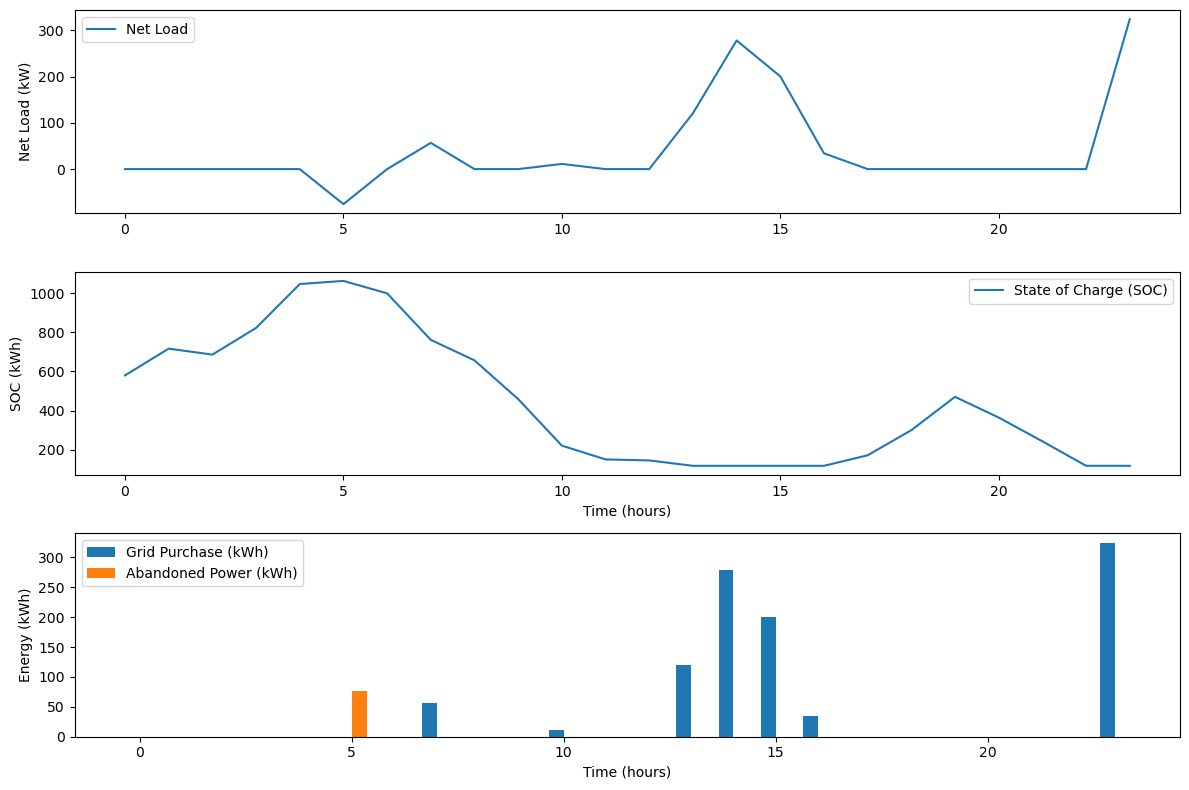

In [6]:

# 储能系统参数
storage_power = 250  # kW
storage_capacity = 1180 # kWh
charge_discharge_efficiency = 0.95
soc_min = 0.1
soc_max = 0.9
lifetime = 10  # years

# 初始化SOC
soc = 0.5 * storage_capacity  # 初始SOC设为50%容量

# 购电价格
grid_price = 1  # 元/kWh
wind_price = 0.5  # 元/kWh

# 储能系统成本计算
storage_cost_power = storage_power * 800  # 元
storage_cost_energy = storage_capacity * 1800  # 元
total_storage_cost = (storage_cost_power + storage_cost_energy) / (lifetime * 365 * 24)  # 元/h

# 储能运行策略函数
def storage_operation(load, wind, soc, storage_capacity, storage_power, charge_discharge_efficiency, soc_min, soc_max):
    net_load = load - wind
    if net_load > 0:
        # 负荷大于发电量，需要放电
        discharge = min(net_load, storage_power, (soc - soc_min * storage_capacity) / charge_discharge_efficiency)
        soc -= discharge * charge_discharge_efficiency
        net_load -= discharge
    else:
        # 发电量大于负荷，需要充电
        charge = min(-net_load, storage_power, (soc_max * storage_capacity - soc) * charge_discharge_efficiency)
        soc += charge / charge_discharge_efficiency
        net_load += charge
    
    # 确保SOC在范围内
    soc = max(soc_min * storage_capacity, min(soc, soc_max * storage_capacity))
    
    return net_load, soc

# 模拟一天的运行
load_b = load_data_b['Load_B'].values
wind_b = generation_data_b['Wind_B'].values
net_load_b = []
soc_values_b = []

for i in range(len(load_b)):
    net_load, soc = storage_operation(load_b[i], wind_b[i], soc, storage_capacity, storage_power, charge_discharge_efficiency, soc_min, soc_max)
    net_load_b.append(net_load)
    soc_values_b.append(soc)

# 转为numpy数组
net_load_b = np.array(net_load_b)
soc_values_b = np.array(soc_values_b)

# 计算购电量和弃电量
grid_purchase_b = np.maximum(net_load_b, 0)
abandoned_wind_b = np.maximum(-net_load_b, 0) * (generation_data_b['Wind_B'].values > 0)

# 计算总供电成本
total_grid_cost_b = np.sum(grid_purchase_b * grid_price)
total_wind_cost_b = np.sum(np.minimum(wind_b, load_b) * wind_price)

total_cost_b = total_grid_cost_b + total_wind_cost_b + total_storage_cost * len(load_b)

# 未配置储能时的购电量和总供电成本
grid_purchase_no_storage_b = np.maximum(load_b - wind_b, 0)
total_grid_cost_no_storage_b = np.sum(grid_purchase_no_storage_b * grid_price)
total_wind_cost_no_storage_b = np.sum(np.minimum(wind_b, load_b) * wind_price)

total_cost_no_storage_b = total_grid_cost_no_storage_b + total_wind_cost_no_storage_b

# 打印结果
print(f"配置储能后的总供电成本: {total_cost_b} 元")
print(f"未配置储能时的总供电成本: {total_cost_no_storage_b} 元")

# 绘制SOC和净负荷变化图
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(net_load_b, label='Net Load')
plt.ylabel('Net Load (kW)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(soc_values_b, label='State of Charge (SOC)')
plt.ylabel('SOC (kWh)')
plt.legend()

plt.xlabel('Time (hours)')

# 绘制供电量柱状图
time = np.arange(len(load_b))
width = 0.35

plt.subplot(3, 1, 3)
plt.bar(time - width/2, grid_purchase_b, width, label='Grid Purchase (kWh)')
plt.bar(time + width/2, abandoned_wind_b, width, label='Abandoned Power (kWh)')
plt.ylabel('Energy (kWh)')
plt.xlabel('Time (hours)')
plt.legend()

plt.tight_layout()
plt.show()


C园区：

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取Excel文件
load_data_c = pd.read_excel('附件1：各园区典型日负荷数据.xlsx', sheet_name='Sheet1')
generation_data_c = pd.read_excel('附件2：各园区典型日风光发电数据.xlsx', sheet_name='Sheet1')

# 打印列名
print("Load Data C Columns:", load_data_c.columns)
print("Generation Data C Columns:", generation_data_c.columns)

# 如果需要，重命名列
#load_data_c = load_data_c.rename(columns={'原来的列名1': 'Load_C', '原来的列名2': '其他列'})
#generation_data_c = generation_data_c.rename(columns={'原来的列名3': 'Wind_C', '原来的列名4': 'PV_C'})


Load Data C Columns: Index(['时间（h）', 'Load_A', 'Purchase_A', 'Different_A', 'Load_B', 'Purchase_B',
       'Different_B', 'Load_C', 'Purchase_C'],
      dtype='object')
Generation Data C Columns: Index(['时间（h）', 'Solar_A', 'Wind_A', 'Wind_B', 'Solar_C', 'Wind_C', 'So_A',
       'W_A', 'W_B', 'Solar_C.1', 'W_C'],
      dtype='object')


In [8]:

# 储能系统参数
storage_power = 250  # kW
storage_capacity = 1180  # kWh
charge_discharge_efficiency = 0.95
soc_min = 0.1
soc_max = 0.9
lifetime = 10  # years

# 初始化SOC
soc = 0.5 * storage_capacity  # 初始SOC设为50%容量

# 购电价格
grid_price = 1  # 元/kWh
wind_price = 0.5  # 元/kWh
salor_price = 0.4  # 元/kWh

# 储能系统成本计算
storage_cost_power = storage_power * 800  # 元
storage_cost_energy = storage_capacity * 1800  # 元
total_storage_cost = (storage_cost_power + storage_cost_energy) / (lifetime * 365 * 24)  # 元/h


In [9]:

# 储能运行策略函数
def storage_operation(load, wind, solar, soc, storage_capacity, storage_power, charge_discharge_efficiency, soc_min, soc_max):
    net_load = load - wind - solar
    if net_load > 0:
        # 负荷大于发电量，需要放电
        discharge = min(net_load, storage_power, (soc - soc_min * storage_capacity) / charge_discharge_efficiency)
        soc -= discharge * charge_discharge_efficiency
        net_load -= discharge
    else:
        # 发电量大于负荷，需要充电
        charge = min(-net_load, storage_power, (soc_max * storage_capacity - soc) * charge_discharge_efficiency)
        soc += charge / charge_discharge_efficiency
        net_load += charge
    
    # 确保SOC在范围内
    soc = max(soc_min * storage_capacity, min(soc, soc_max * storage_capacity))
    
    return net_load, soc


In [10]:

# 模拟一天的运行
load_c = load_data_c['Load_C'].values
wind_c = generation_data_c['Wind_C'].values


In [11]:
solar_c = generation_data_c['Solar_C'].values
net_load_c = []
soc_values_c = []
for i in range(len(load_c)):
    net_load, soc = storage_operation(load_c[i], wind_c[i], solar_c[i], soc, storage_capacity, storage_power, charge_discharge_efficiency, soc_min, soc_max)
    net_load_c.append(net_load)
    soc_values_c.append(soc)

In [12]:

# 转为numpy数组
net_load_c = np.array(net_load_c)
soc_values_c = np.array(soc_values_c)


In [13]:

# 计算购电量和弃电量
grid_purchase_c = np.maximum(net_load_c, 0)
abandoned_power_c = np.maximum(-net_load_c, 0) * (generation_data_c['Wind_C'].values + generation_data_c['Solar_C'].values > 0)


In [14]:

# 计算总供电成本
total_grid_cost_c = np.sum(grid_purchase_c * grid_price)
total_wind_cost_c = np.sum(np.minimum(wind_c, load_c) * wind_price)
total_solar_cost_c = np.sum(np.minimum(solar_c, load_c - np.minimum(wind_c, load_c)) * solar_price)

total_cost_c = total_grid_cost_c + total_wind_cost_c + total_solar_cost_c + total_storage_cost * len(load_c)


In [15]:

# 未配置储能时的购电量和总供电成本
grid_purchase_no_storage_c = np.maximum(load_c - wind_c - solar_c, 0)
total_grid_cost_no_storage_c = np.sum(grid_purchase_no_storage_c * grid_price)
total_wind_cost_no_storage_c = np.sum(np.minimum(wind_c, load_c) * wind_price)
total_pv_cost_no_storage_c = np.sum(np.minimum(solar_c, load_c - np.minimum(wind_c, load_c)) * solar_price)

total_cost_no_storage_c = total_grid_cost_no_storage_c + total_wind_cost_no_storage_c + total_pv_cost_no_storage_c

# 打印结果
print(f"配置储能后的总供电成本: {total_cost_c} 元")
print(f"未配置储能时的总供电成本: {total_cost_no_storage_c} 元")


配置储能后的总供电成本: 4096.083060069062 元
未配置储能时的总供电成本: 5014.994 元


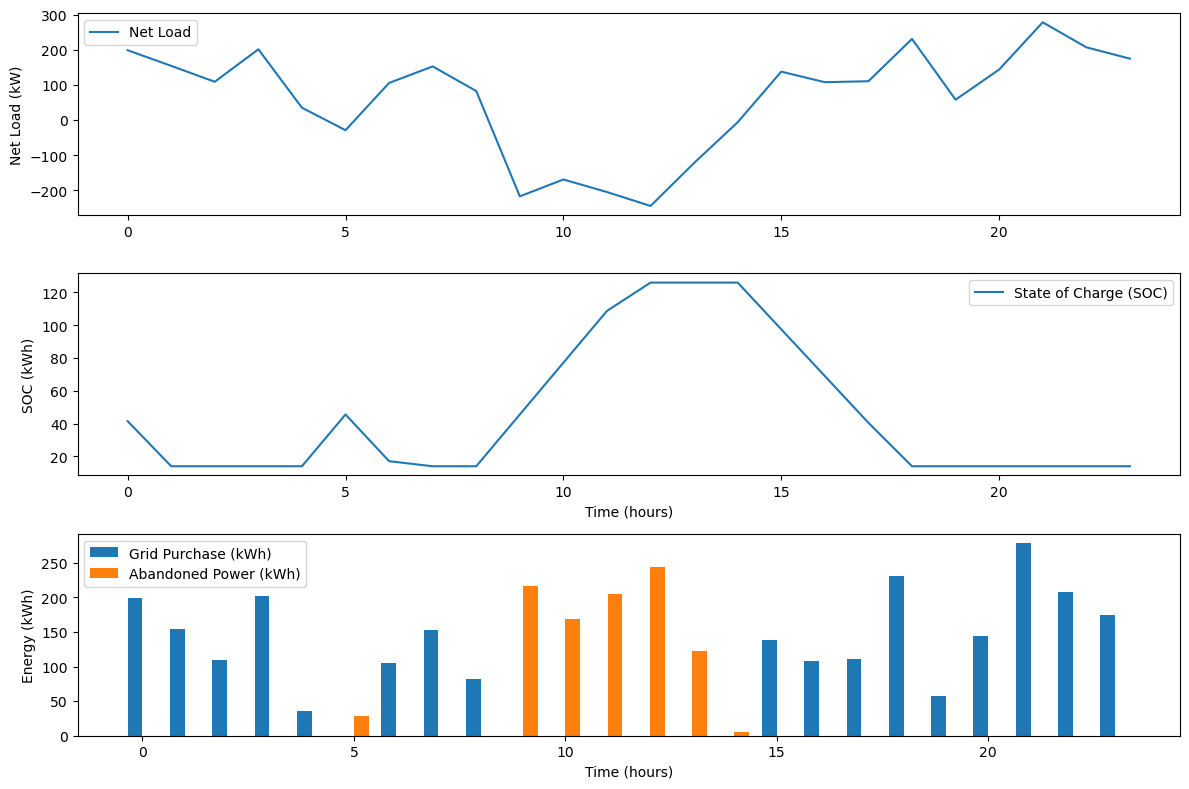

In [275]:

# 绘制SOC和净负荷变化图
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(net_load_c, label='Net Load')
plt.ylabel('Net Load (kW)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(soc_values_c, label='State of Charge (SOC)')
plt.ylabel('SOC (kWh)')
plt.legend()

plt.xlabel('Time (hours)')

# 绘制供电量柱状图
time = np.arange(len(load_c))
width = 0.35

plt.subplot(3, 1, 3)
plt.bar(time - width/2, grid_purchase_c, width, label='Grid Purchase (kWh)')
plt.bar(time + width/2, abandoned_power_c, width, label='Abandoned Power (kWh)')
plt.ylabel('Energy (kWh)')
plt.xlabel('Time (hours)')
plt.legend()

plt.tight_layout()
plt.show()


（3）假设风光荷功率波动特性保持上述条件不变，你认为 50kW/100kWh 的
方案是否最优？若是，请给出分析依据；若不是，请制定各园区最优的储能功率、
容量配置方案，论证所制定方案的优越性。

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取Excel文件
load_data = pd.read_excel('附件1：各园区典型日负荷数据.xlsx', sheet_name='Sheet1')
generation_data = pd.read_excel('附件2：各园区典型日风光发电数据.xlsx', sheet_name='Sheet1')

# 打印列名以确保正确读取
print("Load Data Columns:", load_data.columns)
print("Generation Data Columns:", generation_data.columns)

# 如果需要，重命名列
load_data = load_data.rename(columns={'原来的列名1': 'Load_A', '原来的列名2': '其他列'})
generation_data = generation_data.rename(columns={'原来的列名3': 'Solar_A', '原来的列名4': 'Wind_A'})

# 储能系统参数
charge_discharge_efficiency = 0.95
soc_min = 0.1
soc_max = 0.9
lifetime = 10  # years

# 初始化SOC
initial_soc = 0.5  # 初始SOC设为50%容量

# 购电价格
grid_price = 1  # 元/kWh
wind_price = 0.5  # 元/kWh
solar_price = 0.4  # 元/kWh


Load Data Columns: Index(['时间（h）', 'Load_A', 'Purchase_A', 'Different_A', 'Load_B', 'Purchase_B',
       'Different_B', 'Load_C', 'Purchase_C'],
      dtype='object')
Generation Data Columns: Index(['时间（h）', 'Solar_A', 'Wind_A', 'Solar_B', 'Wind_B', 'Solar_C', 'Wind_C',
       'So_A', 'W_A', 'W_B', 'Solar_C.1', 'W_C'],
      dtype='object')


In [36]:

# 储能运行策略函数
def storage_operation(load, solar, wind, soc, storage_capacity, storage_power, charge_discharge_efficiency, soc_min, soc_max):
    net_load = load - solar - wind
    if net_load > 0:
        # 负荷大于发电量，需要放电
        discharge = min(net_load, storage_power, (soc - soc_min * storage_capacity) / charge_discharge_efficiency)
        soc -= discharge * charge_discharge_efficiency
        net_load -= discharge
    else:
        # 发电量大于负荷，需要充电
        charge = min(-net_load, storage_power, (soc_max * storage_capacity - soc) * charge_discharge_efficiency)
        soc += charge / charge_discharge_efficiency
        net_load += charge
    
    # 确保SOC在范围内
    soc = max(soc_min * storage_capacity, min(soc, soc_max * storage_capacity))
    
    return net_load, soc


In [66]:

# 模拟一天的运行
def simulate(storage_power, storage_capacity):
    soc = initial_soc * storage_capacity
    load_a = load_data['Load_A'].values
    solar_a = generation_data['Solar_A'].values
    wind_a = generation_data['Wind_A'].values
    net_load_a = []
    soc_values_a = []

    for i in range(len(load_a)):
        net_load, soc = storage_operation(load_a[i], solar_a[i], wind_a[i], soc, storage_capacity, storage_power, charge_discharge_efficiency, soc_min, soc_max)
        net_load_a.append(net_load)
        soc_values_a.append(soc)

    # 转为numpy数组
    net_load_a = np.array(net_load_a)
    soc_values_a = np.array(soc_values_a)

    # 计算购电量和弃电量
    grid_purchase_a = np.maximum(net_load_a, 0)
    abandoned_solar_a = np.maximum(-net_load_a, 0) * (generation_data['Solar_A'].values > 0)
    abandoned_wind_a = np.maximum(-net_load_a, 0) * (generation_data['Wind_A'].values > 0)

    # 计算总供电成本
    total_grid_cost_a = np.sum(grid_purchase_a * grid_price)
    total_wind_cost_a = np.sum(np.minimum(wind_a, load_a - solar_a) * wind_price)
    total_solar_cost_a = np.sum(np.minimum(solar_a, load_a - wind_a) * solar_price)

    storage_cost_power = storage_power * 800  # 元
    storage_cost_energy = storage_capacity * 1800  # 元
    total_storage_cost = (storage_cost_power + storage_cost_energy) / (lifetime * 365 * 24)  # 元/h

    total_cost_a = total_grid_cost_a + total_wind_cost_a + total_solar_cost_a + total_storage_cost * len(load_a)
    total_grid_purchase_a = np.sum(grid_purchase_a)  # 总购电量
    total_abandoned_solar_a = np.sum(abandoned_solar_a)  # 总弃光电量
    total_abandoned_wind_a = np.sum(abandoned_wind_a)  # 总弃风电量
    average_cost_a = total_cost_a / np.sum(load_a)  # 单位电量平均供电成本

    # 未配置储能时的购电量和总供电成本
    grid_purchase_no_storage_a = np.maximum(load_a - solar_a - wind_a, 0)
    total_grid_cost_no_storage_a = np.sum(grid_purchase_no_storage_a * grid_price)
    total_wind_cost_no_storage_a = np.sum(np.minimum(wind_a, load_a - solar_a) * wind_price)
    total_solar_cost_no_storage_a = np.sum(np.minimum(solar_a, load_a - wind_a) * solar_price)

    total_cost_no_storage_a = total_grid_cost_no_storage_a + total_wind_cost_no_storage_a + total_solar_cost_no_storage_a
    total_grid_purchase_no_storage_a = np.sum(grid_purchase_no_storage_a)  # 未配置储能时的总购电量
    average_cost_no_storage_a = total_cost_no_storage_a / np.sum(load_a)  # 未配置储能时的单位电量平均供电成本

    return total_cost_a, total_cost_no_storage_a, total_grid_purchase_a, total_grid_purchase_no_storage_a, total_abandoned_solar_a, total_abandoned_wind_a, soc_values_a, average_cost_a, average_cost_no_storage_a

# 测试不同配置
storage_powers = [30,40,50]
storage_capacities = [140,150,185,200]

results = []

for power in storage_powers:
    for capacity in storage_capacities:
        total_cost_a, total_cost_no_storage_a, total_grid_purchase_a, total_grid_purchase_no_storage_a, total_abandoned_solar_a, total_abandoned_wind_a, soc_values_a, average_cost_a, average_cost_no_storage_a = simulate(power, capacity)
        results.append((power, capacity, total_cost_a, total_cost_no_storage_a, total_grid_purchase_a, total_grid_purchase_no_storage_a, total_abandoned_solar_a, total_abandoned_wind_a, average_cost_a, average_cost_no_storage_a))

# 输出结果
for result in results:
    print(f"Storage Power: {result[0]} kW, Storage Capacity: {result[1]} kWh")
    print(f"Total Cost with Storage: {result[2]:.2f} 元, Total Cost without Storage: {result[3]:.2f} 元")
    print(f"Total Grid Purchase with Storage: {result[4]:.2f} kWh, Total Grid Purchase without Storage: {result[5]:.2f} kWh")
    print(f"Total Abandoned Solar: {result[6]:.2f} kWh, Total Abandoned Wind: {result[7]:.2f} kWh")
    print(f"Average Cost with Storage: {result[8]:.2f} 元/kWh, Average Cost without Storage: {result[9]:.2f} 元/kWh")
    print()

Storage Power: 30 kW, Storage Capacity: 140 kWh
Total Cost with Storage: 5508.05 元, Total Cost without Storage: 5609.27 元
Total Grid Purchase with Storage: 4697.28 kWh, Total Grid Purchase without Storage: 4874.12 kWh
Total Abandoned Solar: 844.80 kWh, Total Abandoned Wind: 0.00 kWh
Average Cost with Storage: 0.70 元/kWh, Average Cost without Storage: 0.71 元/kWh

Storage Power: 30 kW, Storage Capacity: 150 kWh
Total Cost with Storage: 5500.35 元, Total Cost without Storage: 5609.27 元
Total Grid Purchase with Storage: 4684.65 kWh, Total Grid Purchase without Storage: 4874.12 kWh
Total Abandoned Solar: 837.20 kWh, Total Abandoned Wind: 0.00 kWh
Average Cost with Storage: 0.70 元/kWh, Average Cost without Storage: 0.71 元/kWh

Storage Power: 30 kW, Storage Capacity: 185 kWh
Total Cost with Storage: 5473.40 元, Total Cost without Storage: 5609.27 元
Total Grid Purchase with Storage: 4640.44 kWh, Total Grid Purchase without Storage: 4874.12 kWh
Total Abandoned Solar: 810.60 kWh, Total Abandoned W

模拟B园区

In [56]:
# 模拟一天的运行
def simulate(storage_power, storage_capacity):
    soc = initial_soc * storage_capacity
    load_b = load_data['Load_B'].values
    solar_b = generation_data['Solar_B'].values
    wind_b = generation_data['Wind_B'].values
    net_load_b = []
    soc_values_b = []

    for i in range(len(load_b)):
        net_load, soc = storage_operation(load_b[i], solar_b[i], wind_b[i], soc, storage_capacity, storage_power, charge_discharge_efficiency, soc_min, soc_max)
        net_load_b.append(net_load)
        soc_values_b.append(soc)

    # 转为numpy数组
    net_load_b = np.array(net_load_b)
    soc_values_b = np.array(soc_values_b)

    # 计算购电量和弃电量
    grid_purchase_b = np.maximum(net_load_b, 0)
    abandoned_solar_b = np.maximum(-net_load_b, 0) * (generation_data['Solar_B'].values > 0)
    abandoned_wind_b = np.maximum(-net_load_b, 0) * (generation_data['Wind_B'].values > 0)

    # 计算总供电成本
    total_grid_cost_b = np.sum(grid_purchase_b * grid_price)
    total_wind_cost_b = np.sum(np.minimum(wind_b, load_b - solar_b) * wind_price)
    total_solar_cost_b = np.sum(np.minimum(solar_b, load_b - wind_b) * solar_price)

    storage_cost_power = storage_power * 800  # 元
    storage_cost_energy = storage_capacity * 1800  # 元
    total_storage_cost = (storage_cost_power + storage_cost_energy) / (lifetime * 365 * 24)  # 元/h

    total_cost_b = total_grid_cost_b + total_wind_cost_b + total_solar_cost_b + total_storage_cost * len(load_b)
    total_grid_purchase_b = np.sum(grid_purchase_b)  # 总购电量
    total_abandoned_solar_b = np.sum(abandoned_solar_b)  # 总弃光电量
    total_abandoned_wind_b = np.sum(abandoned_wind_b)  # 总弃风电量
    average_cost_b = total_cost_b / np.sum(load_b)  # 单位电量平均供电成本

    # 未配置储能时的购电量和总供电成本
    grid_purchase_no_storage_b = np.maximum(load_b - solar_b - wind_b, 0)
    total_grid_cost_no_storage_b = np.sum(grid_purchase_no_storage_b * grid_price)
    total_wind_cost_no_storage_b = np.sum(np.minimum(wind_b, load_b - solar_b) * wind_price)
    total_solar_cost_no_storage_b = np.sum(np.minimum(solar_b, load_b - wind_b) * solar_price)

    total_cost_no_storage_b = total_grid_cost_no_storage_b + total_wind_cost_no_storage_b + total_solar_cost_no_storage_b
    total_grid_purchase_no_storage_b = np.sum(grid_purchase_no_storage_b)  # 未配置储能时的总购电量
    average_cost_no_storage_b = total_cost_no_storage_b / np.sum(load_b)  # 未配置储能时的单位电量平均供电成本

    return total_cost_b, total_cost_no_storage_b, total_grid_purchase_b, total_grid_purchase_no_storage_b, total_abandoned_solar_b, total_abandoned_wind_b, soc_values_b, average_cost_b, average_cost_no_storage_b

# 测试不同配置
storage_powers = [56]
storage_capacities = [180]

results = []

for power in storage_powers:
    for capacity in storage_capacities:
        total_cost_b, total_cost_no_storage_b, total_grid_purchase_b, total_grid_purchase_no_storage_b, total_abandoned_solar_b, total_abandoned_wind_b, soc_values_b, average_cost_b, average_cost_no_storage_b = simulate(power, capacity)
        results.append((power, capacity, total_cost_b, total_cost_no_storage_b, total_grid_purchase_b, total_grid_purchase_no_storage_b, total_abandoned_solar_b, total_abandoned_wind_b, average_cost_b, average_cost_no_storage_b))

# 输出结果
for result in results:
    print(f"Storage Power: {result[0]} kW, Storage Capacity: {result[1]} kWh")
    print(f"Total Cost with Storage: {result[2]:.2f} 元, Total Cost without Storage: {result[3]:.2f} 元")
    print(f"Total Grid Purchase with Storage: {result[4]:.2f} kWh, Total Grid Purchase without Storage: {result[5]:.2f} kWh")
    print(f"Total Abandoned Solar: {result[6]:.2f} kWh, Total Abandoned Wind: {result[7]:.2f} kWh")
    print(f"Average Cost with Storage: {result[8]:.2f} 元/kWh, Average Cost without Storage: {result[9]:.2f} 元/kWh")
    print()



Storage Power: 56 kW, Storage Capacity: 180 kWh
Total Cost with Storage: 4466.93 元, Total Cost without Storage: 4712.15 元
Total Grid Purchase with Storage: 2086.04 kWh, Total Grid Purchase without Storage: 2432.30 kWh
Total Abandoned Solar: 0.00 kWh, Total Abandoned Wind: 653.40 kWh
Average Cost with Storage: 0.58 元/kWh, Average Cost without Storage: 0.61 元/kWh



In [62]:
def simulate(storage_power, storage_capacity):
    soc = initial_soc * storage_capacity
    load_c = load_data['Load_C'].values
    solar_c = generation_data['Solar_C'].values
    wind_c = generation_data['Wind_C'].values
    net_load_c = []
    soc_values_c = []

    for i in range(len(load_c)):
        net_load, soc = storage_operation(load_c[i], solar_c[i], wind_c[i], soc, storage_capacity, storage_power, charge_discharge_efficiency, soc_min, soc_max)
        net_load_c.append(net_load)
        soc_values_c.append(soc)

    # 转为numpy数组
    net_load_c = np.array(net_load_c)
    soc_values_c = np.array(soc_values_c)

    # 计算购电量和弃电量
    grid_purchase_c = np.maximum(net_load_c, 0)
    abandoned_solar_c = np.maximum(-net_load_c, 0) * (generation_data['Solar_C'].values > 0)
    abandoned_wind_c = np.maximum(-net_load_c, 0) * (generation_data['Wind_C'].values > 0)

    # 计算总供电成本
    total_grid_cost_c = np.sum(grid_purchase_c * grid_price)
    total_wind_cost_c = np.sum(np.minimum(wind_c, load_c - solar_c) * wind_price)
    total_solar_cost_c = np.sum(np.minimum(solar_c, load_c - wind_c) * solar_price)

    storage_cost_power = storage_power * 800  # 元
    storage_cost_energy = storage_capacity * 1800  # 元
    total_storage_cost = (storage_cost_power + storage_cost_energy) / (lifetime * 365 * 24)  # 元/h

    total_cost_c = total_grid_cost_c + total_wind_cost_c + total_solar_cost_c + total_storage_cost * len(load_c)
    total_grid_purchase_c = np.sum(grid_purchase_c)  # 总购电量
    total_abandoned_solar_c = np.sum(abandoned_solar_c)  # 总弃光电量
    total_abandoned_wind_c = np.sum(abandoned_wind_c)  # 总弃风电量
    average_cost_c = total_cost_c / np.sum(load_c)  # 单位电量平均供电成本

    return total_cost_c, total_grid_purchase_c, total_abandoned_solar_c, total_abandoned_wind_c, average_cost_c

# 测试不同配置
storage_powers = [60,70,80,90]
storage_capacities = [100,130,170,220]

results = []

for power in storage_powers:
    for capacity in storage_capacities:
        total_cost_c, total_grid_purchase_c, total_abandoned_solar_c, total_abandoned_wind_c, average_cost_c = simulate(power, capacity)
        results.append((power, capacity, total_cost_c, total_grid_purchase_c, total_abandoned_solar_c, total_abandoned_wind_c, average_cost_c))

# 输出结果
for result in results:
    print(f"Storage Power: {result[0]} kW, Storage Capacity: {result[1]} kWh")
    print(f"Total Cost with Storage: {result[2]:.2f} 元")
    print(f"Total Grid Purchase with Storage: {result[3]:.2f} kWh")
    print(f"Total Abandoned Solar: {result[4]:.2f} kWh, Total Abandoned Wind: {result[5]:.2f} kWh")
    print(f"Average Cost with Storage: {result[6]:.2f} 元/kWh")
    print()

Storage Power: 60 kW, Storage Capacity: 100 kWh
Total Cost with Storage: 4327.91 元
Total Grid Purchase with Storage: 2507.98 kWh
Total Abandoned Solar: 993.27 kWh, Total Abandoned Wind: 993.27 kWh
Average Cost with Storage: 0.56 元/kWh

Storage Power: 60 kW, Storage Capacity: 130 kWh
Total Cost with Storage: 4304.81 元
Total Grid Purchase with Storage: 2470.08 kWh
Total Abandoned Solar: 970.47 kWh, Total Abandoned Wind: 970.47 kWh
Average Cost with Storage: 0.55 元/kWh

Storage Power: 60 kW, Storage Capacity: 170 kWh
Total Cost with Storage: 4274.01 元
Total Grid Purchase with Storage: 2419.56 kWh
Total Abandoned Solar: 940.07 kWh, Total Abandoned Wind: 940.07 kWh
Average Cost with Storage: 0.55 元/kWh

Storage Power: 60 kW, Storage Capacity: 220 kWh
Total Cost with Storage: 4235.51 元
Total Grid Purchase with Storage: 2356.40 kWh
Total Abandoned Solar: 902.07 kWh, Total Abandoned Wind: 902.07 kWh
Average Cost with Storage: 0.54 元/kWh

Storage Power: 70 kW, Storage Capacity: 100 kWh
Total Co

In [44]:

# 测试不同配置
storage_powers = [30,40,50,60,70]
storage_capacities = [130,140,150,160,170]

results = []

for power in storage_powers:
    for capacity in storage_capacities:
        total_cost_a, total_cost_no_storage_a, abandoned_solar_a, abandoned_wind_a, soc_values_a = simulate(power, capacity)
        results.append((power, capacity, total_cost_a, total_cost_no_storage_a, sum(abandoned_solar_a), sum(abandoned_wind_a)))


ValueError: too many values to unpack (expected 5)

In [41]:

# 找出最优配置
optimal_result = min(results, key=lambda x: x[2])
print(f"最优配置为：储能功率 {optimal_result[0]} kW, 储能容量 {optimal_result[1]} kWh")
print(f"最优配置下的总供电成本: {optimal_result[2]} 元")
print(f"未配置储能时的总供电成本: {optimal_result[3]} 元")
print(f"最优配置下的弃光量: {optimal_result[4]} kWh, 弃风量: {optimal_result[5]} kWh")

# 结果可视化
powers, capacities, total_costs, no_storage_costs, abandoned_solars, abandoned_winds = zip(*results)


最优配置为：储能功率 50 kW, 储能容量 170 kWh
最优配置下的总供电成本: 4477.5287310742615 元
未配置储能时的总供电成本: 4712.15 元
最优配置下的弃光量: 0.0 kWh, 弃风量: 664.8022500000002 kWh


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (25,) and arg 1 with shape (5,).

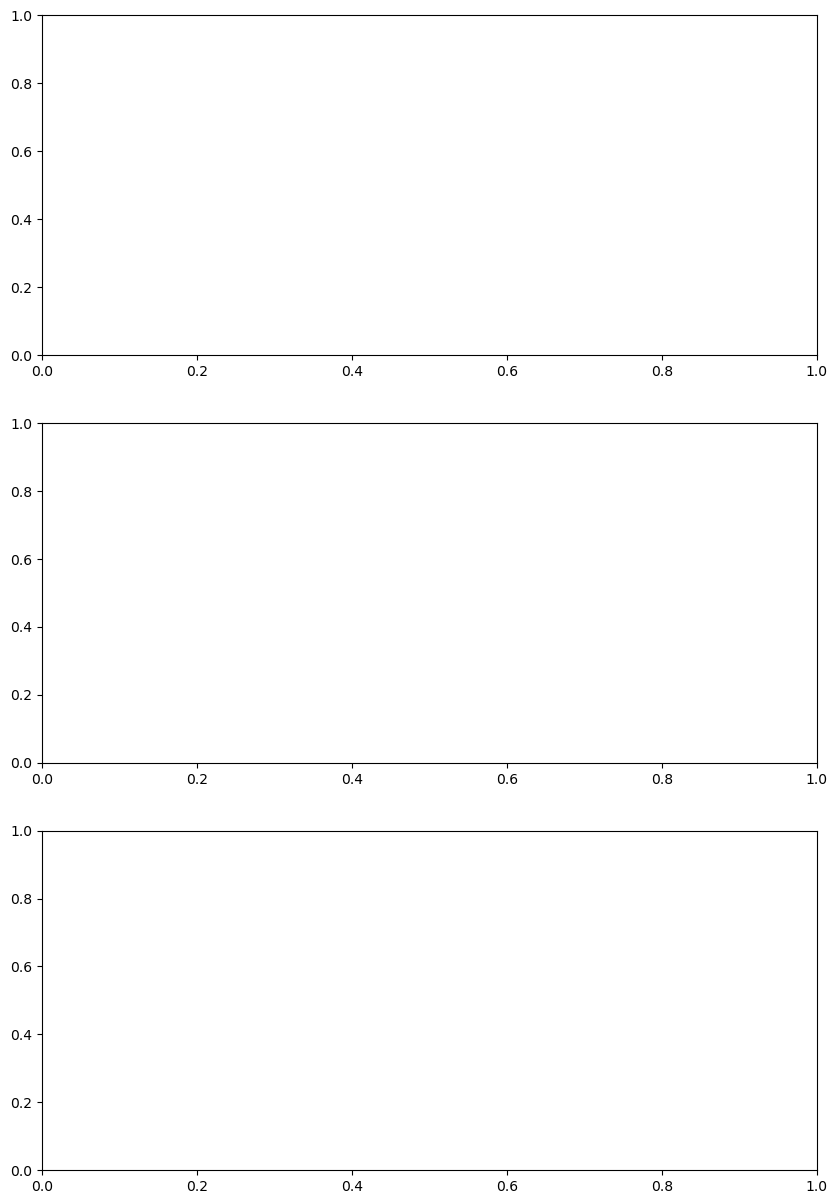

In [28]:

# 绘制总供电成本柱状图
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

x = np.arange(len(powers))
bar_width = 0.2

for i, capacity in enumerate(storage_capacities):
    ax[0].bar(x + i * bar_width, [total_costs[j] for j in range(len(powers)) if capacities[j] == capacity], bar_width, label=f'容量 {capacity} kWh')

ax[0].set_xticks(x + bar_width)
ax[0].set_xticklabels([f'{power} kW' for power in storage_powers])
ax[0].set_xlabel('储能功率')
ax[0].set_ylabel('总供电成本 (元)')
ax[0].set_title('不同配置下的总供电成本')
ax[0].legend()


In [24]:

# 绘制弃电量柱状图
for i, capacity in enumerate(storage_capacities):
    ax[1].bar(x + i * bar_width, [abandoned_solars[j] for j in range(len(powers)) if capacities[j] == capacity], bar_width, label=f'弃光 (容量 {capacity} kWh)')
    ax[1].bar(x + i * bar_width, [abandoned_winds[j] for j in range(len(powers)) if capacities[j] == capacity], bar_width, bottom=[abandoned_solars[j] for j in range(len(powers)) if capacities[j] == capacity], label=f'弃风 (容量 {capacity} kWh)')

ax[1].set_xticks(x + bar_width)
ax[1].set_xticklabels([f'{power} kW' for power in storage_powers])
ax[1].set_xlabel('储能功率')
ax[1].set_ylabel('弃电量 (kWh)')
ax[1].set_title('不同配置下的弃电量')
ax[1].legend()

# 绘制SOC变化折线图
for i, capacity in enumerate(storage_capacities):
    ax[2].plot(range(len(soc_values_a)), [soc for j, soc in enumerate(soc_values_a) if capacities[j] == capacity and powers[j] == storage_powers[1]], label=f'容量 {capacity} kWh')

ax[2].set_xlabel('时间 (小时)')
ax[2].set_ylabel('SOC (kWh)')
ax[2].set_title('SOC变化')
ax[2].legend()

plt.tight_layout()
plt.show()


IndexError: list index out of range

In [29]:
import numpy as np

# 假设适应度函数计算总供电成本，示例函数
def fitness_function(storage_power, storage_capacity):
    total_cost = (storage_power * 100) + (storage_capacity * 10)
    return total_cost

# 初始化种群
def initialize_population(pop_size, power_range, capacity_range):
    population = []
    for _ in range(pop_size):
        power = np.random.uniform(*power_range)
        capacity = np.random.uniform(*capacity_range)
        population.append((power, capacity))
    return population

# 选择适应度最好的个体
def select_best_individual(population, fitness_func):
    best_individual = min(population, key=lambda ind: fitness_func(*ind))
    return best_individual

# 交叉操作
def crossover(parent1, parent2):
    alpha = np.random.rand()
    child1 = (alpha * parent1[0] + (1 - alpha) * parent2[0],
              alpha * parent1[1] + (1 - alpha) * parent2[1])
    child2 = ((1 - alpha) * parent1[0] + alpha * parent2[0],
              (1 - alpha) * parent1[1] + alpha * parent2[1])
    return child1, child2

# 变异操作
def mutate(individual, power_range, capacity_range, mutation_rate=0.1):
    if np.random.rand() < mutation_rate:
        individual = (np.random.uniform(*power_range), individual[1])
    if np.random.rand() < mutation_rate:
        individual = (individual[0], np.random.uniform(*capacity_range))
    return individual

# 例子群算法主程序
def example_group_algorithm(pop_size, power_range, capacity_range, generations, fitness_func):
    population = initialize_population(pop_size, power_range, capacity_range)
    for generation in range(generations):
        new_population = []
        for i in range(0, pop_size, 2):
            parent1 = select_best_individual(population, fitness_func)
            parent2 = select_best_individual(population, fitness_func)
            child1, child2 = crossover(parent1, parent2)
            new_population.append(mutate(child1, power_range, capacity_range))
            new_population.append(mutate(child2, power_range, capacity_range))
        population = new_population
        best_individual = select_best_individual(population, fitness_func)
        print(f"Generation {generation}: Best solution {best_individual}, Fitness {fitness_func(*best_individual)}")
    return best_individual

# 参数设置
pop_size = 200
power_range = (30, 70)  # 储能功率范围
capacity_range = (130, 170)  # 储能容量范围
generations = 100

# 运行算法
best_solution = example_group_algorithm(pop_size, power_range, capacity_range, generations, fitness_function)
print(f"Optimal Storage Configuration: Power {best_solution[0]} kW, Capacity {best_solution[1]} kWh")


Generation 0: Best solution (30.747504204168962, 131.70851017255728), Fitness 4391.835522142469
Generation 1: Best solution (30.747504204168962, 131.70851017255728), Fitness 4391.835522142469
Generation 2: Best solution (30.747504204168962, 130.93888107931252), Fitness 4384.1392312100215
Generation 3: Best solution (30.593297828116096, 130.93888107931252), Fitness 4368.718593604735
Generation 4: Best solution (30.46977929987948, 130.93888107931252), Fitness 4356.3667407810735
Generation 5: Best solution (30.46977929987948, 130.93888107931252), Fitness 4356.3667407810735
Generation 6: Best solution (30.46977929987948, 130.93888107931252), Fitness 4356.3667407810735
Generation 7: Best solution (30.13160535730051, 130.93888107931252), Fitness 4322.549346523176
Generation 8: Best solution (30.131605357300508, 130.93888107931252), Fitness 4322.549346523176
Generation 9: Best solution (30.131605357300508, 130.770213806624), Fitness 4320.862673796291
Generation 10: Best solution (30.131605357

In [291]:
import numpy as np

# 假设适应度函数计算总供电成本，示例函数
def fitness_function(storage_power, storage_capacity):
    total_cost = (storage_power * 100) + (storage_capacity * 10)
    return total_cost

# 初始化种群
def initialize_population(pop_size, power_range, capacity_range):
    population = []
    for _ in range(pop_size):
        power = np.random.uniform(*power_range)
        capacity = np.random.uniform(*capacity_range)
        population.append((power, capacity))
    return population

# 选择适应度最好的个体
def select_best_individual(population, fitness_func):
    best_individual = min(population, key=lambda ind: fitness_func(*ind))
    return best_individual

# 选择父代个体
def select_parents(population, fitness_func, num_parents):
    fitness_values = np.array([fitness_func(*ind) for ind in population])
    selected_indices = np.argsort(fitness_values)[:num_parents]
    parents = [population[i] for i in selected_indices]
    return parents

# 交叉操作
def crossover(parent1, parent2):
    alpha = np.random.rand()
    child1 = (alpha * parent1[0] + (1 - alpha) * parent2[0],
              alpha * parent1[1] + (1 - alpha) * parent2[1])
    child2 = ((1 - alpha) * parent1[0] + alpha * parent2[0],
              (1 - alpha) * parent1[1] + alpha * parent2[1])
    return child1, child2

# 变异操作
def mutate(individual, power_range, capacity_range, mutation_rate=0.1):
    if np.random.rand() < mutation_rate:
        individual = (np.random.uniform(*power_range), individual[1])
    if np.random.rand() < mutation_rate:
        individual = (individual[0], np.random.uniform(*capacity_range))
    return individual

# 遗传算法主程序
def genetic_algorithm(pop_size, power_range, capacity_range, generations, fitness_func, num_parents=4, mutation_rate=0.1):
    population = initialize_population(pop_size, power_range, capacity_range)
    for generation in range(generations):
        new_population = []
        parents = select_parents(population, fitness_func, num_parents)
        while len(new_population) < pop_size:
            parent1, parent2 = np.random.choice(parents, size=2, replace=False)
            child1, child2 = crossover(parent1, parent2)
            new_population.append(mutate(child1, power_range, capacity_range, mutation_rate))
            new_population.append(mutate(child2, power_range, capacity_range, mutation_rate))
        population = new_population[:pop_size]
        best_individual = select_best_individual(population, fitness_func)
        print(f"Generation {generation}: Best solution {best_individual}, Fitness {fitness_func(*best_individual)}")
    return best_individual

# 参数设置
pop_size = 10
power_range = (40, 60)  # 储能功率范围
capacity_range = (80, 120)  # 储能容量范围
generations = 50

# 运行算法
best_solution = genetic_algorithm(pop_size, power_range, capacity_range, generations, fitness_function)
print(f"Optimal Storage Configuration: Power {best_solution[0]} kW, Capacity {best_solution[1]} kWh")


ValueError: a must be 1-dimensional

C

In [42]:
import pandas as pd
import numpy as np

# 假设文件路径和表名正确
file_path = '联合园区_1.xlsx'

# 读取数据
data = pd.read_excel(file_path, sheet_name=None)
load_data = data['Load']  # 根据实际sheet名
generation_data = data['generation_data']  # 根据实际sheet名

# 打印列名进行检查
print("Load Data Columns:", load_data.columns)
print("Generation Data Columns:", generation_data.columns)

# 假设初始储能状态
initial_soc = 0.5  # 初始SOC为50%
charge_discharge_efficiency = 0.95
soc_min = 0.1
soc_max = 0.9
grid_price = 1.0  # 购电价格为1元/kWh
wind_price = 0.5  # 风电价格为0.5元/kWh
solar_price = 0.4  # 光伏电价格为0.4元/kWh
lifetime = 10  # 储能系统寿命为10年

def storage_operation(load, solar, wind, soc, capacity, power, efficiency, soc_min, soc_max):
    surplus = solar + wind - load
    if surplus > 0:
        charge_power = min(surplus, power)
        soc += charge_power * efficiency
        soc = min(soc, capacity * soc_max)
        net_load = load - (solar + wind - charge_power)
    else:
        discharge_power = min(-surplus, power)
        soc -= discharge_power / efficiency
        soc = max(soc, capacity * soc_min)
        net_load = load - (solar + wind + discharge_power)
    return net_load, soc

# 模拟一天的运行
def simulate(storage_power, storage_capacity):
    soc = initial_soc * storage_capacity
    load_b = load_data['Load_B'].values
    solar_b = generation_data['Solar_B'].values
    wind_b = generation_data['Wind_B'].values
    net_load_b = []
    soc_values_b = []

    for i in range(len(load_b)):
        net_load, soc = storage_operation(load_b[i], solar_b[i], wind_b[i], soc, storage_capacity, storage_power, charge_discharge_efficiency, soc_min, soc_max)
        net_load_b.append(net_load)
        soc_values_b.append(soc)

    # 转为numpy数组
    net_load_b = np.array(net_load_b)
    soc_values_b = np.array(soc_values_b)

    # 计算购电量和弃电量
    grid_purchase_b = np.maximum(net_load_b, 0)
    abandoned_solar_b = np.maximum(-net_load_b, 0) * (generation_data['Solar_B'].values > 0)
    abandoned_wind_b = np.maximum(-net_load_b, 0) * (generation_data['Wind_B'].values > 0)

    # 计算总供电成本
    total_grid_cost_b = np.sum(grid_purchase_b * grid_price)
    total_wind_cost_b = np.sum(np.minimum(wind_b, load_b - solar_b) * wind_price)
    total_solar_cost_b = np.sum(np.minimum(solar_b, load_b - wind_b) * solar_price)

    storage_cost_power = storage_power * 800  # 元
    storage_cost_energy = storage_capacity * 1800  # 元
    total_storage_cost = (storage_cost_power + storage_cost_energy) / (lifetime * 365 * 24)  # 元/h

    total_cost_b = total_grid_cost_b + total_wind_cost_b + total_solar_cost_b + total_storage_cost * len(load_b)
    total_grid_purchase_b = np.sum(grid_purchase_b)  # 总购电量
    total_abandoned_solar_b = np.sum(abandoned_solar_b)  # 总弃光电量
    total_abandoned_wind_b = np.sum(abandoned_wind_b)  # 总弃风电量
    average_cost_b = total_cost_b / np.sum(load_b)  # 单位电量平均供电成本

    # 未配置储能时的购电量和总供电成本
    grid_purchase_no_storage_b = np.maximum(load_b - solar_b - wind_b, 0)
    total_grid_cost_no_storage_b = np.sum(grid_purchase_no_storage_b * grid_price)
    total_wind_cost_no_storage_b = np.sum(np.minimum(wind_b, load_b - solar_b) * wind_price)
    total_solar_cost_no_storage_b = np.sum(np.minimum(solar_b, load_b - wind_b) * solar_price)

    total_cost_no_storage_b = total_grid_cost_no_storage_b + total_wind_cost_no_storage_b + total_solar_cost_no_storage_b
    total_grid_purchase_no_storage_b = np.sum(grid_purchase_no_storage_b)  # 未配置储能时的总购电量
    average_cost_no_storage_b = total_cost_no_storage_b / np.sum(load_b)  # 未配置储能时的单位电量平均供电成本

    return total_cost_b, total_cost_no_storage_b, total_grid_purchase_b, total_grid_purchase_no_storage_b, total_abandoned_solar_b, total_abandoned_wind_b, soc_values_b, average_cost_b, average_cost_no_storage_b

# 测试不同配置
storage_powers = [30, 40, 50, 60, 70]
storage_capacities = [130, 140, 150, 160, 170]

results = []

for power in storage_powers:
    for capacity in storage_capacities:
        total_cost_b, total_cost_no_storage_b, total_grid_purchase_b, total_grid_purchase_no_storage_b, total_abandoned_solar_b, total_abandoned_wind_b, soc_values_b, average_cost_b, average_cost_no_storage_b = simulate(power, capacity)
        results.append((power, capacity, total_cost_b, total_cost_no_storage_b, total_grid_purchase_b, total_grid_purchase_no_storage_b, total_abandoned_solar_b, total_abandoned_wind_b, average_cost_b, average_cost_no_storage_b))

# 输出结果
for result in results:
    print(f"Storage Power: {result[0]} kW, Storage Capacity: {result[1]} kWh")
    print(f"Total Cost with Storage: {result[2]:.2f} 元, Total Cost without Storage: {result[3]:.2f} 元")
    print(f"Total Grid Purchase with Storage: {result[4]:.2f} kWh, Total Grid Purchase without Storage: {result[5]:.2f} kWh")
    print(f"Total Abandoned Solar: {result[6]:.2f} kWh, Total Abandoned Wind: {result[7]:.2f} kWh")
    print(f"Average Cost with Storage: {result[8]:.2f} 元/kWh, Average Cost without Storage: {result[9]:.2f} 元/kWh")
    print()


KeyError: 'load_data'